# Product Ranking as an MIP problem
This notebook is going to serve as tutorial and example on how to solve product ranking as an assignment problem. Concretely, we will define it as a Mixed Integer Programming problem.

## 1. Problem setup

### Variables & position bias

In [1]:
import numpy as np

MAX_SALES = 30
N_PRODUCTS = 20
PRODS = np.arange(N_PRODUCTS)
SALES_FORECAST = np.random.choice(MAX_SALES, N_PRODUCTS)  # max_sales, n_products
POSITIONS = np.random.permutation(PRODS)
POSITION_BIAS = np.geomspace(1, 0.4, N_PRODUCTS)

In [2]:
POSITIONS

array([ 5, 14,  3,  8,  4, 18,  0,  7, 12,  6, 10, 17, 11, 19,  2, 15, 13,
        1, 16,  9])

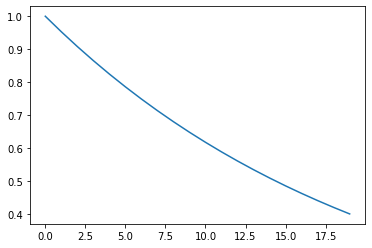

In [3]:
"""DISCOMMENT TO SHOW PLOT (NOT REALLY NEEDED)"""
import seaborn as sns
%matplotlib inline

sns.lineplot(PRODS, POSITION_BIAS)

### Sales extrapolation

In [4]:
def extrapolate_sales(current_position, new_positions, forecasted_sales):
    return np.array([min(MAX_SALES, forecasted_sales * POSITION_BIAS[new_position] / POSITION_BIAS[current_position]) 
            for new_position in new_positions])

In [5]:
extrapolated_sales_matrix = np.array(np.array([extrapolate_sales(POSITIONS[i], PRODS, SALES_FORECAST[i]) 
                                       for i in range(0, len(PRODS))]))

$M_{i, j}$ number of predicted sales of product _i_ at position _j_. 

*Objective*: maximize number of sales

The problem has $n!$ possible solutions. 

In [6]:
from scipy.special import factorial 

print(f'Number of possible solutions {factorial(N_PRODUCTS)}')

Number of possible solutions 2.43290200817664e+18


It seems unfeasible to solve this problem by trying all possible combinations.
We could try a greedy algorithm that tries selects the highest reward for each position. However, this would not lead to a global optimal solution.
So...
Let's define the problem as a Mixed Integer Programming problem!

## Mixed Integer Programming & OR-Tools
In our problem we want to decide product-position pairs in order to maximize our reward. In this case, the reward could be the number of sales, the revenue or the margin generated. We will use the term reward for a general case.
To do so we are going to create an array of coefficients:

$ C_{i, j}\begin{cases} 
      1 & \text{product $i$ selected to position $j$} \\
      0 & \text{otherwise}
   \end{cases}
$

In [7]:
from ortools.linear_solver import pywraplp

# Solver definition
solver = pywraplp.Solver('Ranking_Optimization',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

chosen = {}

for i in range(N_PRODUCTS):
    for j in range(N_PRODUCTS):   # len(prods) = npositions
        chosen[i, j] = solver.BoolVar(f'Prod {i} position {j}')

### The objective function
Our objective is to maximize the number of sales. We need to select pairs product-position such that we maximize the total number of sales.

We can define it then as:

maximize $ \displaystyle\sum_{i, j=0}^{n-1} C_{i, j} * M_{i, j} $

In [8]:
solver.Maximize(solver.Sum([chosen[i, j] * extrapolated_sales_matrix[i,j] for i in range(N_PRODUCTS)
                                                                          for j in range(N_PRODUCTS)]))

### Constraints

If we leave the problem as is the solver will decide to set all products in all positions. However, this is not possible! We need to define constraints to avoid this.

*C1*: One product goes to exactly one position

$ \displaystyle\sum_{i}^{n-1} C_{i, j} = 1, \text{j=\{0..n\}} $

In [9]:
for i in range(0, N_PRODUCTS):
    solver.Add(solver.Sum([chosen[i, j] for j in range(N_PRODUCTS)]) == 1)

*C2*: One position gets just one product

$ \displaystyle\sum_{j}^{n-1} C_{i, j} = 1, \text{i=\{0..n\}} $

In [10]:
for j in range(0, N_PRODUCTS):
    solver.Add(solver.Sum([chosen[i, j] for i in range(N_PRODUCTS)]) == 1)

Finally, solve the problem:

$
\text{maximize} \displaystyle\sum_{i, j=0}^{n-1} C_{i, j} * M_{i, j} \\
\begin{aligned}
\text{subject to} \quad \displaystyle\sum_{i}^{n-1} C_{i, j} = 1, \text{j=\{0..n\}} \\
\displaystyle\sum_{j}^{n-1} C_{i, j} = 1, \text{i=\{0..n\}}
\end{aligned}
$

#### *Extra*: pairs of products that need to go together

In [11]:

pairs = [(0, 2), (5, 7), (9, 11)]
for (prod_x, prod_y) in pairs:
    pos_x = pos_y = 0
    for i in range(0, N_PRODUCTS):
        pos_x += chosen[prod_x, i] * i
    for j in range(0, N_PRODUCTS):
        pos_y += chosen[prod_y, j] * j
    distance = pos_x - pos_y
    solver.Add(distance == -1)

In [12]:
solution = solver.Solve()

In [14]:
print('Total cost = ', solver.Objective().Value())
for i in range(N_PRODUCTS):
    for j in range(N_PRODUCTS):
        if chosen[i, j].solution_value() > 0:
            print(f'Product {i} goes to position {j} and is expected to sell {extrapolated_sales_matrix[i, j]} units') 

Total cost =  319.23724812395346
Product 0 goes to position 11 and is expected to sell 15.723673922269692 units
Product 1 goes to position 0 and is expected to sell 27.50090522827369 units
Product 2 goes to position 12 and is expected to sell 5.831021068349598 units
Product 3 goes to position 16 and is expected to sell 6.119117907588938 units
Product 4 goes to position 10 and is expected to sell 14.226181167767816 units
Product 5 goes to position 4 and is expected to sell 21.607854107929327 units
Product 6 goes to position 18 and is expected to sell 4.197630456732947 units
Product 7 goes to position 5 and is expected to sell 18.721357791997804 units
Product 8 goes to position 19 and is expected to sell 0.7134943249232031 units
Product 9 goes to position 13 and is expected to sell 18.550852448003283 units
Product 10 goes to position 1 and is expected to sell 29.325910161459866 units
Product 11 goes to position 14 and is expected to sell 0.0 units
Product 12 goes to position 3 and is exp

In [15]:
previous_units_sold = sum(SALES_FORECAST)
optimized_units_sold = solver.Objective().Value()

delta = (optimized_units_sold / previous_units_sold  - 1) * 100
print(f'Previous ranking forecast: {previous_units_sold} units'\
      f'\nNew Ranking forecast: {optimized_units_sold} units')
print(f'Expected performance increase wrt before -> {np.round(delta, 3)}%')

Previous ranking forecast: 280 units
New Ranking forecast: 319.23724812395346 units
Expected performance increase wrt before -> 14.013%
